In [1]:
import pandas as pd
import os
from tqdm import tqdm
import pydicom
from ultralytics import YOLO
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as T
import segmentation_models_pytorch as smp
from torch.cuda.amp import autocast
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

/home/abk171/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('cleaned_data.csv')
df

,Unnamed: 0,Number,WristImage Segmentation for AI Analysis,Arm (L/R),Sex,Race,Ethnicity,Age,Clinical Signs of CTS,CTS-6 Score,Measurement at Wrist
0,0,21,Yes,R,M,White,Non-Hispanic,43.0,Y,12.5,12.16
1,1,22,Yes,R,M,White,Unreported/Chose not to disclose,74.0,Y,16.5,20.10
2,2,23,Yes,L,M,White,Unreported/Chose not to disclose,74.0,Y,11.5,13.83
3,3,24,Yes,R,F,Black,Non-Hispanic,63.0,Y,21.0,16.55
4,4,25,Yes,R,M,White,Non-Hispanic,49.0,Y,9.0,19.21
...,...,...,...,...,...,...,...,...,...,...,...
116,117,184,Yes,R,F,White,Non-Hispanic,53.0,Y,NaN,10.58
117,118,185,Yes,L,F,White,Non-Hispanic,47.0,Y,NaN,8.56
118,119,186,Yes,R,F,White,Non-Hispanic,47.0,Y,NaN,11.80
119,120,123,Yes - Double Check,L,F,White,Non-Hispanic,18.0,N,0.0,6.79


Measurement at wrist <- Age, Gender, Image characteristic, clinical signs of cts

In [41]:
restructured_root = 'data_yolo'
image_dir = os.path.join(restructured_root, 'images')
image_train_dir = os.path.join(image_dir, 'train')
image_val_dir = os.path.join(image_dir, 'val')
image_test_dir = os.path.join(image_dir, 'test')
label_dir = os.path.join(restructured_root, 'labels')
label_train_dir = os.path.join(label_dir, 'train')
label_val_dir = os.path.join(label_dir, 'val')

In [42]:
anno_dir = '/data_vault/hexai02/CarpalTunnel/Annotations'
dicom_dir = '/data_vault/hexai02/CarpalTunnel/Images'

In [43]:
from Utilities.utilities import load_dicom, load_mask, load_model

In [44]:
model = YOLO("runs/detect/train17/weights/best.pt")
model.eval()
print('YOLO loaded')

YOLO loaded


In [45]:
config = {
    'epochs': 40,
    'in_channels': 1,
    'dropout': 0.2,
    'decoder_attention_type': 'scse',
    'init_lr': 5e-4,
    'weight_decay': 0.05,
    'T_max': 10,
    'eta_min': 3e-5
}

In [47]:
device = "cuda" if torch.cuda.is_available() else "cpu"

unet_model = smp.Unet(encoder_name="resnet18",in_channels=1,dropout=config['in_channels'],decoder_attention_type=config['decoder_attention_type']).to(device)

# unet_model, _, _, _ = load_model(unet_model, optimizer=None, scheduler=None, path=f'unet_runs/epoch_40.pth')
checkpoint = torch.load('unet_runs/epoch_40.pth', map_location="cuda")
unet_model.load_state_dict(checkpoint, strict=True)
unet_model.eval()
print('UNET loaded')

UNET loaded


In [64]:
train_images = []
train_labels = []
val_images = []
val_labels = []


image_transform = T.Compose([
    T.Resize((512, 512), interpolation=T.InterpolationMode.BILINEAR),  
    T.Normalize(mean=[0.5], std=[0.5]),  
])

def fill_arr(img_dir, img_bucket, mask_bucket):
    for jpg_name in tqdm(os.listdir(img_dir)): 
        entry_name = jpg_name.split('.')[0]
        img_filename = entry_name + '.dcm'

        # df['Clinical Signs of CTS'].unique()
        clinical_signs = df.loc[df['Number'] == entry_name, 'Clinical Signs of CTS'].values
        if len(clinical_signs) == 0:
            print(f"{entry_name}")
            continue
        classification_tensor = torch.tensor([1 if clinical_signs[0] == 'Y' else 0], dtype=torch.uint8)
        
        # Load DICOM image
        img = load_dicom(os.path.join(dicom_dir, img_filename))

        # Get bounding box from YOLO
        result = model(img, save=False, verbose=False)
        box = result[0].boxes
        
        if len(box.xyxy.tolist()) == 0:
            continue  
        mask_bucket.append(classification_tensor)

        x1, y1, x2, y2 = map(int, box.xyxy.tolist()[0])
        img_slice = img[y1:y2, x1:x2, 0]  # Crop the region


        img_tensor = torch.from_numpy(img_slice).float()  # Convert to float


        img_tensor = img_tensor / 255.0  


        if img_tensor.dim() == 2:
            img_tensor = img_tensor.unsqueeze(0).unsqueeze(0)  # Convert (H, W) → (1, H, W)


        img_tensor = image_transform(img_tensor)  
        

        img_tensor = img_tensor.to(device)


        with torch.no_grad():
            mask_gpu = unet_model(img_tensor)  
        

        img_resized = img_tensor.squeeze().cpu().detach().numpy()  
        mask = mask_gpu.squeeze().cpu().detach().numpy()  


        img_2channel = np.stack((img_resized, mask), axis=0)
        img_bucket.append(img_2channel)

        

fill_arr(image_train_dir, train_images, train_labels)
fill_arr(image_val_dir, val_images, val_labels)

  4%|█▋                                         | 4/101 [00:00<00:13,  7.46it/s]

43


 87%|████████████████████████████████████▌     | 88/101 [00:11<00:01,  8.91it/s]

163


100%|███████████████████████████████████████████| 19/19 [00:02<00:00,  7.03it/s]


In [65]:
len(val_labels)

17

In [66]:
import torch
import random
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from Utilities.dataloaders import ClassificationDataset

transform = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=10),
    # T.ColorJitter(brightness=0.2, contrast=0.2),
    T.GaussianBlur(kernel_size=3),
])

# Creating Dataset
train_dataset = ClassificationDataset(train_images, train_labels, transform=transform)
val_dataset = ClassificationDataset(val_images, val_labels, transform=None)  # No augmentation for validation

# Creating DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)



In [23]:
for image, label in train_loader:
    print(image.shape, label.shape)
    break

torch.Size([32, 2, 512, 512]) torch.Size([32, 1])


In [24]:
def visualize_batch(images, labels):
    
    batch_size = 5  # 29 in your case
    fig, axes = plt.subplots(batch_size, 2, figsize=(6, batch_size * 3))

    if batch_size == 1:
        axes = [axes]  # Ensure iterable for batch size = 1

    for i in range(batch_size):
        img = images[i, 0].cpu().numpy()  # First channel (image)
        mask = images[i, 1].cpu().numpy()  # Second channel (mask)
        label = labels[i].item() if isinstance(labels, torch.Tensor) else labels[i]

        # Show first channel (original image)
        axes[i, 0].imshow(img, cmap='gray')
        axes[i, 0].set_title(f"Label: {label}")
        axes[i, 0].axis("off")

        # Show second channel (mask)
        axes[i, 1].imshow(mask, cmap='jet')
        axes[i, 1].set_title("Mask")
        axes[i, 1].axis("off")

    plt.tight_layout()
    plt.show()


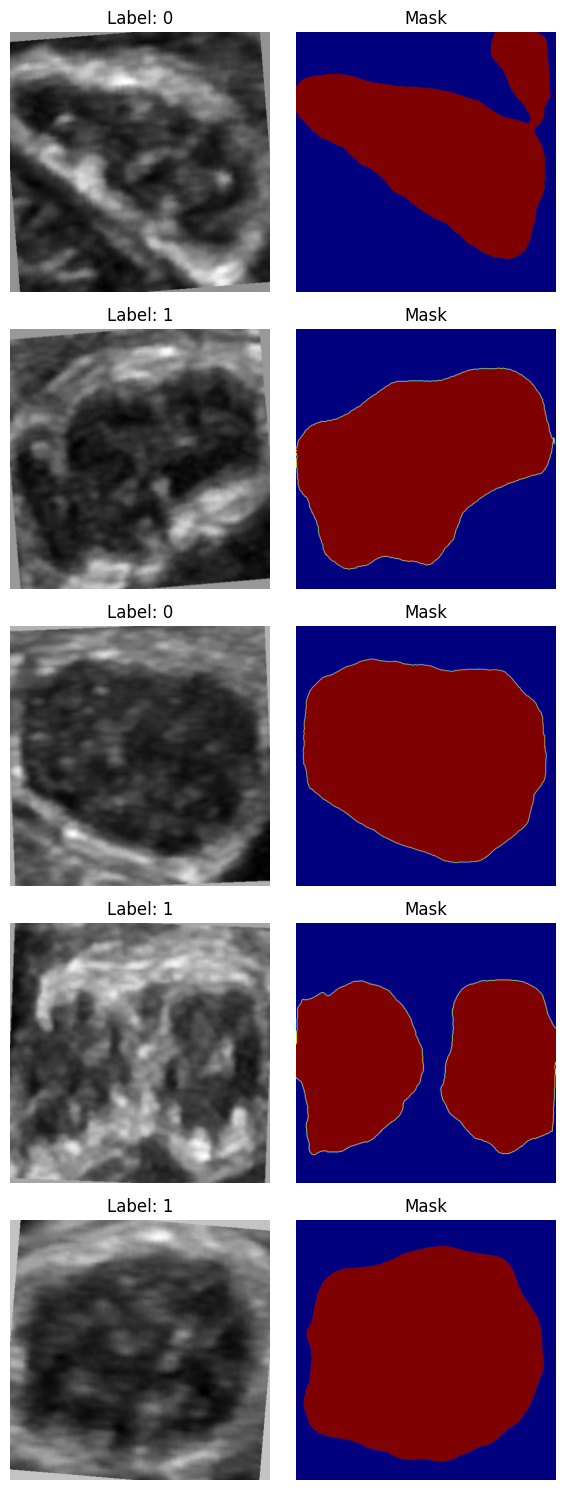

In [25]:
visualize_batch(image, label)

In [77]:
from Utilities.models import *
summary(FullModel(ConvNext(in_chans=2,dims=[96,192,384,768],stages=[1,1,3,1]), 
                  ClassificationTail(768,num_classes=2,dropout_rate=0.2)), (2,512,512),device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 96, 128, 128]           3,168
         LayerNorm-2         [-1, 128, 128, 96]             192
       myLayerNorm-3         [-1, 96, 128, 128]               0
            Conv2d-4         [-1, 96, 128, 128]           4,800
         LayerNorm-5         [-1, 128, 128, 96]             192
            Linear-6        [-1, 128, 128, 384]          37,248
              GELU-7        [-1, 128, 128, 384]               0
            Linear-8         [-1, 128, 128, 96]          36,960
         Dropout2d-9         [-1, 128, 128, 96]               0
  ConvNeXtBlock2D-10         [-1, 96, 128, 128]               0
        LayerNorm-11         [-1, 128, 128, 96]             192
      myLayerNorm-12         [-1, 96, 128, 128]               0
           Conv2d-13          [-1, 192, 64, 64]          73,920
           Conv2d-14          [-1, 192,

In [78]:
config = {
    'epochs': 40,
    'in_channels': 2,
    'dropout': 0.2,
    'init_lr': 5e-4,
    'weight_decay': 0.05,
    'T_max': 10,
    'eta_min': 3e-5
}

In [79]:
EPOCHS = 40

classModel = FullModel(ConvNext(in_chans=2,dims=[96,192,384,768],stages=[1,1,3,1]), 
                  ClassificationTail(768,num_classes=2,dropout_rate=0.2)).to(device)


criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(classModel.parameters(),
                              lr=5e-4)

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2, threshold=1e-1, factor=0.7)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max= config['T_max'],
        eta_min=config['eta_min'])

scaler = torch.cuda.amp.GradScaler()

/tmp/ipykernel_372269/650121702.py:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [41]:
from Utilities.utilities import AverageMeter

In [42]:
def train_loop(dtl, model, criterion, optimizer, scaler):
    model.train()
    loss_m = AverageMeter()
    
    batch_bar = tqdm(total=len(dtl), dynamic_ncols=True, leave=False, position=0, desc='Train')

    for imgs_batch, targets_batch in dtl:
        imgs_batch = imgs_batch.to(device)
        targets_batch = targets_batch.to(device).squeeze(1)  # Fix shape for CrossEntropyLoss

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            predictions = model(imgs_batch)
            loss = criterion(predictions, targets_batch)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        loss_m.update(loss.item())

        # Get learning rate
        current_lr = optimizer.param_groups[0]['lr']

        # Update progress bar
        batch_bar.set_postfix(
            loss="{:.04f}".format(loss_m.avg),
            lr="{:.06f}".format(current_lr)  # Print learning rate
        )
        batch_bar.update()

    batch_bar.close()



    print("Train Loss: {:.04f} | LR: {:.06f}".format(loss_m.avg, current_lr))
    return loss_m.avg


def val_loop(dtl, model, criterion):
    model.eval()
    loss_m = AverageMeter()
    correct = 0
    total = 0

    true_pos = 0
    false_pos = 0
    false_neg = 0

    batch_bar = tqdm(total=len(dtl), dynamic_ncols=True, leave=False, position=0, desc='Val')

    with torch.no_grad():
        for imgs_batch, targets_batch in dtl:
            imgs_batch = imgs_batch.to(device)
            targets_batch = targets_batch.to(device).squeeze(1)  # [B] shape

            predictions = model(imgs_batch)
            loss = criterion(predictions, targets_batch)
            loss_m.update(loss.item())

            preds = predictions.argmax(dim=1)

            # Accuracy
            correct += (preds == targets_batch).sum().item()
            total += targets_batch.size(0)

            # Precision/Recall tracking
            true_pos += ((preds == 1) & (targets_batch == 1)).sum().item()
            false_pos += ((preds == 1) & (targets_batch == 0)).sum().item()
            false_neg += ((preds == 0) & (targets_batch == 1)).sum().item()

            batch_bar.set_postfix(
                loss="{:.04f}".format(loss_m.avg),
                acc="{:.02f}%".format(100 * correct / total)
            )
            batch_bar.update()

    batch_bar.close()

    val_acc = 100 * correct / total
    precision = true_pos / (true_pos + false_pos + 1e-8)
    recall = true_pos / (true_pos + false_neg + 1e-8)

    print("Val Loss: {:.04f} | Acc: {:.02f}% | Precision: {:.02f} | Recall: {:.02f}".format(
        loss_m.avg, val_acc, precision, recall))

    return loss_m.avg, val_acc#, precision, recall


In [43]:

def run_training(
    model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, scaler, num_epochs, save_dir="checkpoints"
):
    # Ensure save directory exists
    os.makedirs(save_dir, exist_ok=True)

    best_loss = float("inf")  # Track best validation loss

    for epoch in range(1, num_epochs + 1):
        print(f"\nEpoch [{epoch}/{num_epochs}]")

        # Train
        train_loss = train_loop(train_dataloader, model, criterion, optimizer, scaler)
        
        # Validate
        val_loss, val_acc = val_loop(val_dataloader, model, criterion)

        # scheduler.step(val_loss) # for ReduceLROnPlateau
        scheduler.step()

        # Save model checkpoint
        checkpoint_path = os.path.join(save_dir, f"epoch_{epoch}.pth")
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Model saved: {checkpoint_path}")

        # Save best model (optional)
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_path = os.path.join(save_dir, "best_model.pth")
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model updated: {best_model_path}")


In [44]:
run_training(
    classModel,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    scaler,
    EPOCHS,
    save_dir='classification_runs'
)


Epoch [1/40]


/tmp/ipykernel_1840454/543328071.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
                                                          

Train Loss: 0.6886 | LR: 0.000500


Val Loss: 0.7160 | Acc: 35.29% | Precision: 0.35 | Recall: 1.00
Model saved: classification_runs/epoch_1.pth
Best model updated: classification_runs/best_model.pth

Epoch [2/40]


Train Loss: 0.6039 | LR: 0.000488


Val Loss: 0.8570 | Acc: 35.29% | Precision: 0.35 | Recall: 1.00
Model saved: classification_runs/epoch_2.pth

Epoch [3/40]


Train Loss: 0.6180 | LR: 0.000455


Val Loss: 0.9739 | Acc: 35.29% | Precision: 0.35 | Recall: 1.00
Model saved: classification_runs/epoch_3.pth

Epoch [4/40]


Train Loss: 0.5837 | LR: 0.000403


Val Loss: 0.9216 | Acc: 35.29% | Precision: 0.35 | Recall: 1.00
Model saved: classification_runs/epoch_4.pth

Epoch [5/40]


Train Loss: 0.5535 | LR: 0.000338


Val Loss: 0.8162 | Acc: 35.29% | Precision: 0.35 | Recall: 1.00
Model saved: classification_runs/epoch_5.pth

Epoch [6/40]


Train Loss: 0.5560 | LR: 0.000265


Val Loss: 0.6400 | Acc: 64.71% | Precision: 0.50 | Recall: 1.00
Model saved: classification_runs/epoch_6.pth
Best model updated: classification_runs/best_model.pth

Epoch [7/40]


Train Loss: 0.5362 | LR: 0.000192


Val Loss: 0.5978 | Acc: 94.12% | Precision: 0.86 | Recall: 1.00
Model saved: classification_runs/epoch_7.pth
Best model updated: classification_runs/best_model.pth

Epoch [8/40]


Train Loss: 0.5299 | LR: 0.000127


Val Loss: 0.5684 | Acc: 88.24% | Precision: 0.83 | Recall: 0.83
Model saved: classification_runs/epoch_8.pth
Best model updated: classification_runs/best_model.pth

Epoch [9/40]


Train Loss: 0.5407 | LR: 0.000075


Val Loss: 0.5632 | Acc: 94.12% | Precision: 0.86 | Recall: 1.00
Model saved: classification_runs/epoch_9.pth
Best model updated: classification_runs/best_model.pth

Epoch [10/40]


Train Loss: 0.5441 | LR: 0.000042


Val Loss: 0.5466 | Acc: 94.12% | Precision: 0.86 | Recall: 1.00
Model saved: classification_runs/epoch_10.pth
Best model updated: classification_runs/best_model.pth

Epoch [11/40]


Train Loss: 0.5814 | LR: 0.000030


Val Loss: 0.5296 | Acc: 88.24% | Precision: 0.75 | Recall: 1.00
Model saved: classification_runs/epoch_11.pth
Best model updated: classification_runs/best_model.pth

Epoch [12/40]


Train Loss: 0.5545 | LR: 0.000042


Val Loss: 0.5518 | Acc: 70.59% | Precision: 0.55 | Recall: 1.00
Model saved: classification_runs/epoch_12.pth

Epoch [13/40]


Train Loss: 0.5365 | LR: 0.000075


Val Loss: 0.6575 | Acc: 64.71% | Precision: 0.50 | Recall: 1.00
Model saved: classification_runs/epoch_13.pth

Epoch [14/40]


Train Loss: 0.5481 | LR: 0.000127


Val Loss: 0.7659 | Acc: 52.94% | Precision: 0.43 | Recall: 1.00
Model saved: classification_runs/epoch_14.pth

Epoch [15/40]


Train Loss: 0.5212 | LR: 0.000192


Val Loss: 0.4765 | Acc: 64.71% | Precision: 0.50 | Recall: 0.83
Model saved: classification_runs/epoch_15.pth
Best model updated: classification_runs/best_model.pth

Epoch [16/40]


Train Loss: 0.5429 | LR: 0.000265


Val Loss: 0.5854 | Acc: 70.59% | Precision: 0.60 | Recall: 0.50
Model saved: classification_runs/epoch_16.pth

Epoch [17/40]


Train Loss: 0.5551 | LR: 0.000338


Val Loss: 1.5074 | Acc: 64.71% | Precision: 0.50 | Recall: 1.00
Model saved: classification_runs/epoch_17.pth

Epoch [18/40]


Train Loss: 0.5362 | LR: 0.000403


Val Loss: 2.4210 | Acc: 58.82% | Precision: 0.46 | Recall: 1.00
Model saved: classification_runs/epoch_18.pth

Epoch [19/40]


Train Loss: 0.5613 | LR: 0.000455


Val Loss: 1.0719 | Acc: 70.59% | Precision: 0.55 | Recall: 1.00
Model saved: classification_runs/epoch_19.pth

Epoch [20/40]


Train Loss: 0.5570 | LR: 0.000488


Val Loss: 0.5669 | Acc: 76.47% | Precision: 0.60 | Recall: 1.00
Model saved: classification_runs/epoch_20.pth

Epoch [21/40]


Train Loss: 0.5780 | LR: 0.000500


Val Loss: 0.4907 | Acc: 76.47% | Precision: 0.60 | Recall: 1.00
Model saved: classification_runs/epoch_21.pth

Epoch [22/40]


Train Loss: 0.5867 | LR: 0.000488


Val Loss: 0.4636 | Acc: 82.35% | Precision: 0.67 | Recall: 1.00
Model saved: classification_runs/epoch_22.pth
Best model updated: classification_runs/best_model.pth

Epoch [23/40]


Train Loss: 0.5582 | LR: 0.000455


Val Loss: 0.4303 | Acc: 94.12% | Precision: 0.86 | Recall: 1.00
Model saved: classification_runs/epoch_23.pth
Best model updated: classification_runs/best_model.pth

Epoch [24/40]


Train Loss: 0.5010 | LR: 0.000403


Val Loss: 0.4864 | Acc: 94.12% | Precision: 0.86 | Recall: 1.00
Model saved: classification_runs/epoch_24.pth

Epoch [25/40]


Train Loss: 0.5217 | LR: 0.000338


Val Loss: 0.4614 | Acc: 82.35% | Precision: 0.80 | Recall: 0.67
Model saved: classification_runs/epoch_25.pth

Epoch [26/40]


Train Loss: 0.5050 | LR: 0.000265


Val Loss: 0.4379 | Acc: 70.59% | Precision: 0.60 | Recall: 0.50
Model saved: classification_runs/epoch_26.pth

Epoch [27/40]


Train Loss: 0.5581 | LR: 0.000192


Val Loss: 0.5558 | Acc: 76.47% | Precision: 0.62 | Recall: 0.83
Model saved: classification_runs/epoch_27.pth

Epoch [28/40]


Train Loss: 0.5082 | LR: 0.000127


Val Loss: 0.7470 | Acc: 64.71% | Precision: 0.50 | Recall: 1.00
Model saved: classification_runs/epoch_28.pth

Epoch [29/40]


Train Loss: 0.5056 | LR: 0.000075


Val Loss: 0.9419 | Acc: 58.82% | Precision: 0.46 | Recall: 1.00
Model saved: classification_runs/epoch_29.pth

Epoch [30/40]


Train Loss: 0.5171 | LR: 0.000042


Val Loss: 0.9489 | Acc: 58.82% | Precision: 0.46 | Recall: 1.00
Model saved: classification_runs/epoch_30.pth

Epoch [31/40]


Train Loss: 0.4803 | LR: 0.000030


Val Loss: 0.8451 | Acc: 58.82% | Precision: 0.46 | Recall: 1.00
Model saved: classification_runs/epoch_31.pth

Epoch [32/40]


Train Loss: 0.4921 | LR: 0.000042


Val Loss: 0.7767 | Acc: 58.82% | Precision: 0.46 | Recall: 1.00
Model saved: classification_runs/epoch_32.pth

Epoch [33/40]


Train Loss: 0.4995 | LR: 0.000075


Val Loss: 0.8066 | Acc: 52.94% | Precision: 0.43 | Recall: 1.00
Model saved: classification_runs/epoch_33.pth

Epoch [34/40]


Train Loss: 0.5203 | LR: 0.000127


Val Loss: 0.8147 | Acc: 58.82% | Precision: 0.46 | Recall: 1.00
Model saved: classification_runs/epoch_34.pth

Epoch [35/40]


Train Loss: 0.5019 | LR: 0.000192


Val Loss: 0.6645 | Acc: 64.71% | Precision: 0.50 | Recall: 1.00
Model saved: classification_runs/epoch_35.pth

Epoch [36/40]


Train Loss: 0.5321 | LR: 0.000265


Val Loss: 0.6353 | Acc: 64.71% | Precision: 0.50 | Recall: 1.00
Model saved: classification_runs/epoch_36.pth

Epoch [37/40]


Train Loss: 0.5004 | LR: 0.000338


Val Loss: 0.5351 | Acc: 82.35% | Precision: 0.67 | Recall: 1.00
Model saved: classification_runs/epoch_37.pth

Epoch [38/40]


Train Loss: 0.5291 | LR: 0.000403


Val Loss: 0.6248 | Acc: 58.82% | Precision: 0.33 | Recall: 0.17
Model saved: classification_runs/epoch_38.pth

Epoch [39/40]


Train Loss: 0.5538 | LR: 0.000455


Val Loss: 0.6043 | Acc: 76.47% | Precision: 0.62 | Recall: 0.83
Model saved: classification_runs/epoch_39.pth

Epoch [40/40]


Train Loss: 0.5146 | LR: 0.000488


Val Loss: 3.0848 | Acc: 35.29% | Precision: 0.35 | Recall: 1.00
Model saved: classification_runs/epoch_40.pth


In [67]:


def visualize_batch(images, labels, cls):
    
    batch_size = images.shape[0]  # 29 in your case
    fig, axes = plt.subplots(batch_size, 2, figsize=(6, batch_size * 3))

    if batch_size == 1:
        axes = [axes]  # Ensure iterable for batch size = 1

    for i in range(batch_size):
        img = images[i, 0].cpu().numpy()  # First channel (image)
        mask = images[i, 1].cpu().numpy()  # Second channel (mask)
        label = labels[i].item() if isinstance(labels, torch.Tensor) else labels[i]
        cls_i = cls[i].item() if isinstance(cls, torch.Tensor) else cls[i]

        # Show first channel (original image)
        axes[i, 0].imshow(img, cmap='gray')
        axes[i, 0].set_title(f"Label: {label}; class: {cls_i}")
        axes[i, 0].axis("off")

        # Show second channel (mask)
        axes[i, 1].imshow(mask, cmap='jet')
        axes[i, 1].set_title("Mask")
        axes[i, 1].axis("off")

        

    plt.tight_layout()
    plt.show()


In [83]:
checkpoint_path = 'classification_runs/epoch_7.pth'
state_dict = torch.load(checkpoint_path, map_location='cuda')  # or 'cuda' if using GPU
classModel.load_state_dict(state_dict)
results = []
ordered_dtl = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=2)
classModel.eval()
with torch.inference_mode():
    for images, _ in ordered_dtl:
        images = images.to(device)
        results.append(classModel.backbone(images))

In [63]:
soft = nn.Softmax(dim=1)

cls = torch.argmax(soft(results),dim=1)

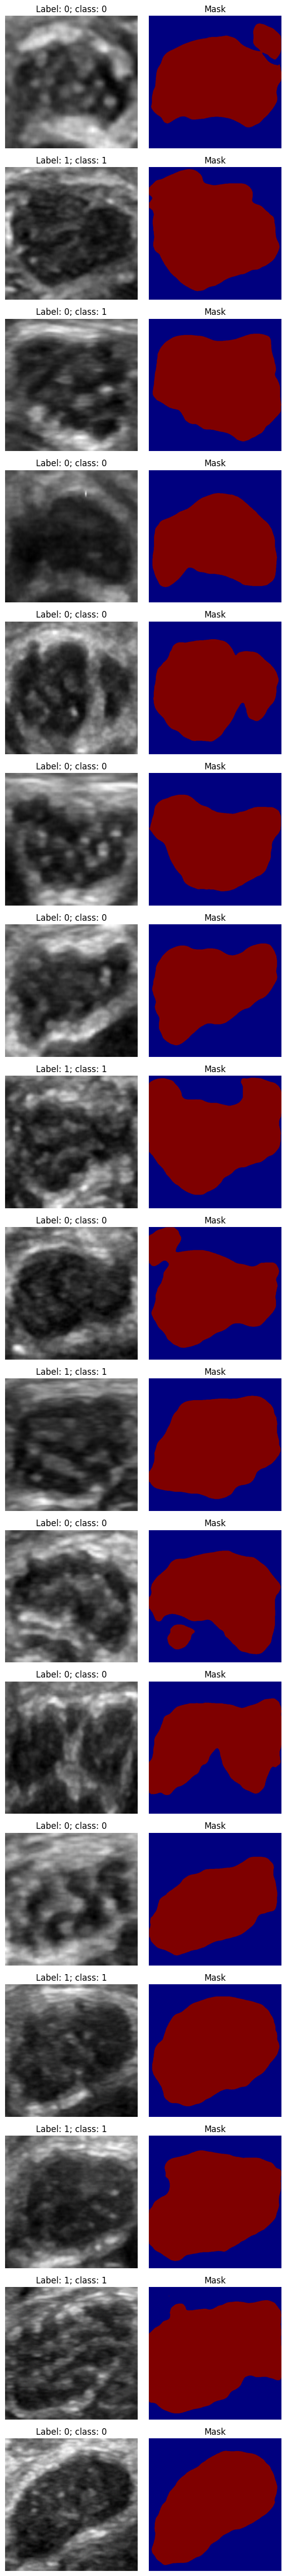

In [68]:
visualize_batch(images, labels, cls)

In [88]:
flattened = torch.cat([tensor.cpu() for tensor in results], dim=0).numpy()

(91, 768)